In [1]:
import models.ResNet

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import WeightedRandomSampler, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

SIZES = ["224", "300", "512"]

device = "cuda" if torch.cuda.is_available() else "cpu"
classes = ["cheetah", "fox", "hyena", "lion", "tiger", "wolf"]

PATH = "~/Documents/datasets/wild_animals"

In [2]:
def norm_transforms(path, size):
    data_dir = path + "/" + size
    transforms = T.Compose(
        [T.Resize((int(size), int(size))), T.ToTensor()]
    )
    dataset = datasets.ImageFolder(root=data_dir, transform=transforms)

    imgs = {}
    for img_t, class_idx in dataset:
        if class_idx in imgs:
            imgs[class_idx].append(img_t)
        else:
            imgs[class_idx] = [img_t]

    norms, unnorms = {}, {}
    for i in range(len(imgs)):
        imgs[i] = torch.stack(imgs[i], dim=3)
        mean = np.array([m for m in imgs[i].view(3, -1).mean(dim=1)])
        std = np.array([s for s in imgs[i].view(3, -1).std(dim=1)])

        norms[i] = T.Normalize(
            mean = mean,
            std = std
        )
        unnorms[i] = T.Normalize(
            mean = -(mean/std),
            std = (1 / std)
        )
    
    return norms, unnorms

In [3]:
def load_data(path, size, norms):
    data_dir = path + "/" + size
    transform = T.Compose(
        [
            T.Resize((int(size), int(size))),
            T.ToTensor(),
        ]
    )
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    
    temp = []
    for (img_t, class_idx) in dataset:
        temp.append((norms[class_idx](img_t), class_idx))
    train_size = int(0.6 * len(dataset))
    test_size = len(dataset) - train_size

    dataset = temp

    train_data, test_data = torch.utils.data.random_split(
        dataset, [train_size, test_size]
    )

    return train_data, test_data

sample_size = SIZES[-1]
norms, unnorms = norm_transforms(PATH, sample_size)
train_data, val_data = load_data(PATH, sample_size, norms)

/usr/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


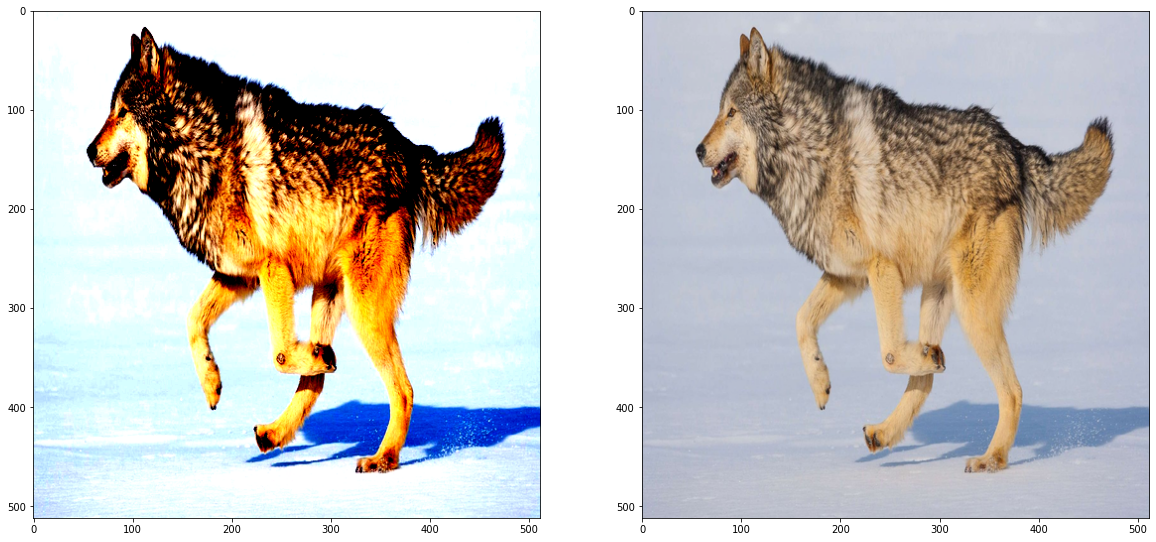

In [12]:
test_img, class_idx = train_data[np.random.randint(0, len(train_data))]
imgs = [test_img.permute(1, 2, 0), unnorms[class_idx](test_img).permute(1, 2, 0)]

fig, axs = plt.subplots(1, 2, figsize=(20, 12))
axs[0].imshow(imgs[0])
axs[1].imshow(imgs[1])

In [5]:
def eval(model, data):
    with torch.no_grad():
        correct = 0

        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)
            pred = model(img_input)
            _, pred = torch.max(pred.squeeze(), 0)
            pred = pred.to("cpu")
            correct += pred.item() == label
        return correct, round((correct / len(data) * 100), 3)

def train(model, train_data, val_data, batch, epochs, lr):
    loader = DataLoader(
        train_data,
        batch_size=batch,
        shuffle=True,
        num_workers=2,
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.0001, momentum=0.9)

    epoch_data = []
    for epoch in range(epochs):
        running_loss, running_acc = 0.0, 0.0
        for i, (imgs, labels) in enumerate(loader):
            inputs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            running_acc += torch.sum(pred == labels).item()

        model.eval()
        _, val_acc = eval(model, val_data)
        model.train()

        running_acc = round(running_acc / len(train_data) * 100, 3)
        running_loss /= len(loader)
        print(f'epoch: {epoch + 1} loss: {running_loss:.6f}')
        epoch_data.append(
            (epoch, float(f"{(running_loss):.6f}"), running_acc, val_acc)
        )
    
    return epoch_data

In [ ]:
def run():
    lr = 0.01
    num_layers = 4
    batch_size = 32
    num_epochs = 75
    runs = []

    norms, unnorms = norm_transforms(PATH, SIZES[-1])
    for size in SIZES:
        model = models.ResNet.ResNet152(len(classes)).to(device)
        train_data, val_data = load_data(PATH, size, norms)
        epoch_data = train(
            model,
            train_data,
            val_data,
            batch_size,
            num_epochs,
            lr
        )
        runs.append(epoch_data)
        del model

    return runs

epoch_data = run()

In [ ]:
train_info = [*zip(*epoch_data)]
acc = np.array(train_info[2]) / 100

fig, axs = plt.subplots(1, 2, figsize=(24, 8))
axs[0].set_title("ResNet Loss", fontsize=20)
axs[1].set_title("ResNet Accuracy", fontsize=20)
axs[0].plot(train_info[0], train_info[1])
axs[1].plot(train_info[0], acc, color="orange")

print(f"ResNet accuracy: {acc[-1]:.3f}")